# setting

In [4]:
import torchvision
import argparse
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import os
from sys import stdout
import pandas as pd


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

from dataloader import RetinopathyLoader


In [2]:
#!pip3 install ipywidgets
#


In [3]:
from ipywidgets import IntProgress

### install library if need

In [4]:
#!pip install torchvision==0.4.0

# dataloader

In [5]:
def str2bool(v):
    if isinstance(v, bool):
       return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

# training

In [5]:

def run(device, train_dataloader, test_dataloader, net, optimizer, criterion):
    train_acc_trend = []
    test_acc_trend = []
    train_loss = []
    test_loss=[]
    fo = open('{}_{}_accuracy.log'.format(NET_NAME, PRETRAINED), "w")
    for epoch in range(1,EPOCH_NUM+1):
        running_loss = 0.0
        print("Epoch {}:".format(epoch))
        fo.write("Epoch {}:\n".format(epoch))
        # training
        net.train()
        train_corr_count = 0
        for idx, (inputs, labels) in enumerate(train_dataloader):
            if idx % 20 == 0:
                stdout.write("\rBatch %i of %i" % (idx, len(train_dataloader)))
                stdout.flush()

            inputs = inputs.to(device)
            labels = labels.to(device).long()

            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #for output loss and accuracy
            running_loss += loss
            pred = torch.max(outputs, 1)[1]  # max index or row
            train_corr_count += pred.eq(labels.data).sum().item()  # .sum().data.cpu().item()
        running_loss /= len(train_dataloader)
        acc_percentage = 100. * train_corr_count / len(train_dataloader.dataset)
        print("train accuracy {}".format(acc_percentage))
        fo.write("train accuracy {}\n".format(acc_percentage))
        train_acc_trend.append(acc_percentage)
        train_loss.append(running_loss)
        net.eval()

        #save model
        save_name = os.path.join(OUTPUT_FOLDER, '{}_{}_{}.pth'.format(NET_NAME, epoch, PRETRAINED))
        torch.save({
          'epoch': epoch,
          'model': net.module.state_dict() if mGPUS else net.state_dict(),
          'optimizer': optimizer.state_dict()
        }, save_name)
        print('save model: {}'.format(save_name))

        # -----------------------------------------

        test_corr_count = 0
        with torch.no_grad():           

            # testing data
            for idx, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device).long()
                outputs = net(inputs)
                
                pred = torch.max(outputs, 1)[1]  # max index or row
                test_corr_count += pred.eq(labels.data).sum().item()

            acc_percentage = 100. * test_corr_count / len(test_dataloader.dataset)
            print("test accuracy {}".format(acc_percentage))
            fo.write("test accuracy {}\n".format(acc_percentage))
            test_acc_trend.append(acc_percentage)

    acc_trend = {'train': train_acc_trend, 'test': test_acc_trend,'loss':train_loss}
    return acc_trend


In [6]:
def main():
    train_dataset = RetinopathyLoader(IMG_PATH, 'train')
    test_dataset = RetinopathyLoader(IMG_PATH, 'test')

    train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    if torch.cuda.is_available():
        print("use cuda")
        device = torch.device('cuda')  # current cuda device
    #        model.cuda()

    else:
        device = torch.device('cpu')

    if NET_NAME == "res18":
        model = torchvision.models.resnet18(pretrained=PRETRAINED)
    else:
        model = torchvision.models.resnet50(pretrained=PRETRAINED)

    model.avgpool = nn.AdaptiveAvgPool2d(1)   # =(1,1)
    in_feature = model.fc.in_features
    model.fc = nn.Linear(in_feature, NUM_CLASSES)  # change fc
    #model.float()
    if mGPUS:
        model = nn.DataParallel(model)
    model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=LR, weight_decay=DECAY)  # , weight_decay=1e-2
    #optimizer = nn.DataParallel(optimizer)  # back propagation also use multiple GPU

    criterion = nn.CrossEntropyLoss()

    # !!! put the network in evaluation mode
    model.eval()

    #acc_trend = run_simple(device, train_loader, test_loader, model, optimizer, criterion, output_folder, net_name)

    acc_trend = run(device, train_loader, test_loader, model, optimizer, criterion)

    print("train acc: {}, test acc:{}".format(acc_trend["train"][-1], acc_trend["test"][-1]))

    
    return model,acc_trend



In [7]:
project_path =  "."


BATCH_SIZE = 16
LR = 0.001
EPOCH_NUM = 3
mGPUS = True
PRETRAINED = True

DECAY = 5e-4
NUM_CLASSES = 5
IMG_PATH = os.path.join(project_path,'data')
OUTPUT_FOLDER = project_path
NET_NAME = "res18"
model_name = "ResNet18"

TRAIN_IMG_PATH = os.path.join(project_path,'train_img_small.csv')
TRAIN_LABEL_PATH = os.path.join(project_path,'train_label_small.csv')
#TEST_IMG_PATH = os.path.join(project_path,'test_img_small.csv')
#TEST_LABEL_PATH = os.path.join(project_path,'test_label_small.csv')
TEST_IMG_PATH = os.path.join(project_path,'test_img.csv')
TEST_LABEL_PATH = os.path.join(project_path,'test_label.csv')





In [8]:
import mlflow
import mlflow.pytorch
from mlflow.models.signature import infer_signature
mlflow.log_param("batch_size",BATCH_SIZE)
mlflow.log_param("learning_rate",LR)
mlflow.log_param("epoch",EPOCH_NUM)
mlflow.log_param("net",NET_NAME)



In [6]:
model,acc_trend = main()

> Found 279 images...
> Found 7025 images...
use cuda
Epoch 1:
Batch 0 of 18train accuracy 65.94982078853046
save model: ./res18_1_True.pth
test accuracy 73.35231316725978
Epoch 2:
Batch 0 of 18train accuracy 73.47670250896057
save model: ./res18_2_True.pth
test accuracy 73.35231316725978
Epoch 3:
Batch 0 of 18train accuracy 73.47670250896057
save model: ./res18_3_True.pth
test accuracy 73.35231316725978
train acc: 73.47670250896057, test acc:73.35231316725978


In [10]:
device = 'cuda'    
####---------------mlflow

mlflow.set_experiment("MyExperiment")

mlflow.start_run()

mlflow.log_metric("cross_entropy_train_loss", acc_trend['loss'][-1].item())
mlflow.log_metric("test_accuracy", acc_trend["test"][-1])
mlflow.log_metric("train_accuracy", acc_trend["train"][-1])

test_dataset = RetinopathyLoader(IMG_PATH, 'test')
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

(inputs, target) = next(iter(test_loader))
#inputs, target = inputs.to(device), target.to(device)

x_test = inputs.numpy().reshape(16,3, 512, 512, 1)

signature = infer_signature(x_test, model(inputs))


data_transform = transforms.Compose([
    transforms.ToTensor(),  # range [0, 255] -> [0.0,1.0]
    ]
)
# Now apply the transformation, expand the batch dimension, and send the image to the GPU
image = Image.open('data/2576_right.jpeg')
image = data_transform(image).unsqueeze(0).cuda()
input_example = image#np.array(train_imgs[0].reshape((1,28,28,1)), dtype=np.uint8)

# 對應參數說明
# 1.訓練完的模型: model
# 2.Artifact的相對路徑: artifact_path="keras-model"
# 3.註冊模型的名稱: registered_model_name="MNIST手寫辨識"
# 4.輸入輸出說明: signature=signature
# 5.輸入範例: input_example=input_example
# 務必!填入相對應的參數資料
mlflow.pytorch.log_model(
model, 
artifact_path="DR_model",
registered_model_name="Diabetic Retinopathy Detection",
signature=signature, 
input_example=input_example)

mlflow.end_run()

> Found 7025 images...


TensorsNotSupportedException: Multidimensional arrays (aka tensors) are not supported. Attempting to infer schema from numpy array with shape (16, 3, 512, 512, 1)

In [9]:
mlflow.end_run()

In [19]:
x_test = inputs.numpy().reshape(16,3, 512, 512, 1)
x_test

array([[[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         ...,

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],


In [9]:
test_data = np.loadtxt("../yp_example/mnist_test.csv", delimiter=",", skiprows=1)
test_imgs = np.asfarray(test_data[:, 1:])


x_test = test_imgs.reshape(test_imgs.shape[0], 28, 28, 1)

    

x_test = x_test.astype('float32')

x_test /= 255

signature = infer_signature(x_test, np.array([4,5,6]))

In [11]:
x_test.type()

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [2]:
import mlflow
mlflow.__version__

'1.21.0'

In [12]:
x_test

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [14]:
inputs.numpy()

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0.

In [47]:
np.array(inputs[0].reshape((1,512,512,3)), dtype=np.uint8)

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

# plot results

In [12]:
def plot_acc_trend(train_pretrained, train_wo, test_pretrained, test_wo):
    plt.figure()
    plt.plot(train_pretrained, label='train (with pretrained)')
    plt.plot(train_wo, marker='.', label='train (w/o pretrained)')
    plt.plot(test_pretrained, label='test (with pretrained)')
    plt.plot(test_wo, marker='.', label='test (w/o pretrained)')

    plt.legend()
    plt.title("Result Comparison ("+model_name+")")
    plt.ylabel("Accuracy(%)")
    plt.xlabel("Epoch")

    image_output_name = "{}_acc.png".format(model_name)
    plt.savefig(image_output_name)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):



    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
        save_cm_name = model_name + 'normalized_cm.png'
        print("Normalized confusion matrix")
    else:
        title = 'Confusion matrix'
        save_cm_name = model_name + '_cm.png'
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure()

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    # plt.tight_layout()
    plt.savefig(save_cm_name)

Normalized confusion matrix
[[9.19852513e-01 2.19289734e-02 5.25907239e-02 5.82185135e-04
  5.04560450e-03]
 [7.29508197e-01 1.00409836e-01 1.55737705e-01 2.04918033e-03
  1.22950820e-02]
 [3.83548983e-01 3.51201479e-02 4.62107209e-01 7.11645102e-02
  4.80591497e-02]
 [6.28571429e-02 0.00000000e+00 3.60000000e-01 4.74285714e-01
  1.02857143e-01]
 [1.81102362e-01 7.87401575e-03 1.81102362e-01 1.10236220e-01
  5.19685039e-01]]
[[4740  113  271    3   26]
 [ 356   49   76    1    6]
 [ 415   38  500   77   52]
 [  11    0   63   83   18]
 [  23    1   23   14   66]]


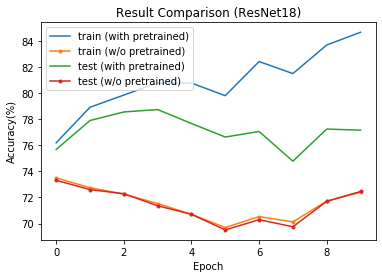

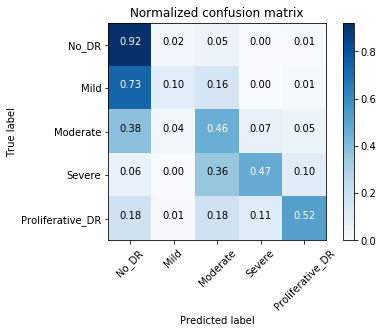

In [14]:
TEST_IMG_PATH = os.path.join(project_path,'test_img.csv')
TEST_LABEL_PATH = os.path.join(project_path,'test_label.csv')
NET_NAME='res50'
# plot trend chart

train_pretrained_acc = []
train_wo_acc = []
test_pretrained_acc = []
test_wo_acc = []

pretrain_list = [True, False]
train_pretrained_acc = []
train_wo_acc = []
test_pretrained_acc = []
test_wo_acc = []
for pretrain in pretrain_list:
    input_file = os.path.join(project_path,NET_NAME+'_'+str(pretrain)+'_accuracy.log')
    fp = open(input_file)

    for line in iter(fp):
        lines = line.split(',')
        if pretrain:

            test_pretrained_acc.append( float(lines[2]))
            train_pretrained_acc.append(float(lines[1]))
        else:
            test_wo_acc.append(float(lines[2]))
            train_wo_acc.append(float(lines[1]))

    fp.close()

#print(train_pretrained_acc)
plot_acc_trend(train_pretrained_acc, train_wo_acc, test_pretrained_acc, test_wo_acc)

# plot confusion matrix
predict_array = np.load(os.path.join(project_path,NET_NAME+'_'+str(PRETRAINED)+'_predict.npy'))
test_img_name, test_label = getData('test')
#test_label = [1, 1, 2, 5, 4, 3, 2, 2, 1, 5, 3, 4, 3, 2, 2, 5]
cm = confusion_matrix(test_label, predict_array)
classes = ('No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR')

plot_confusion_matrix(cm, classes, normalize=PRETRAINED)

print(cm)


# inference

## load model

In [5]:
NUM_CLASSES = 5
model = torchvision.models.resnet50(pretrained=False)
model.avgpool = nn.AdaptiveAvgPool2d(1)   # =(1,1)
in_feature = model.fc.in_features
model.fc = nn.Linear(in_feature, NUM_CLASSES)  # change fc

checkpoint = torch.load('res50_10_True_torch12.pth')
model.load_state_dict(checkpoint['model'])

model.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [6]:

test_dataset = RetinopathyLoader(IMG_PATH, 'test')
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

> Found 7025 images...


In [8]:
device='cuda'

In [13]:
(inputs, target) = next(iter(test_loader))
Loss = nn.CrossEntropyLoss()

testLoss = 0
testCorrectcnt = 0
inputs, target = inputs.to(device), target.to(device)
with torch.no_grad():
    y_pred = model(inputs)
testLoss += Loss(y_pred, target).data.cpu().item()
pred = y_pred.data.max(1)[1]
testCorrectcnt += pred.eq(target.data).sum().data.cpu().item()

testLoss /= len(test_loader)
print('testing loss', testLoss)
print('testing accuracy:', 100. * testCorrectcnt/len(test_loader.dataset))


testing loss 0.0013934885913675483
testing accuracy: 0.199288256227758


In [11]:
test_loader
for idx, (inputs, labels) in enumerate(test_loader):
    print(inputs.shape)
    output = model(inputs)
    print(output)

NameError: name 'test_loader' is not defined

In [14]:

data_transform = transforms.Compose([
    transforms.ToTensor(),  # range [0, 255] -> [0.0,1.0]
]
)
# Load the image
image = Image.open('data/2576_right.jpeg')

# Now apply the transformation, expand the batch dimension, and send the image to the GPU
image = data_transform(image).unsqueeze(0).cuda()
out = model(image)

In [15]:
out

tensor([[ 2.4894,  0.4695,  0.6496, -1.8646, -2.3524]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [16]:
image

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')